In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
from tqdm import tqdm
import emcee
import corner
import plotly.express as px
import re
import glob

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Application to real data

#### WASP-12b (Analytical)

In [18]:
df = pd.read_csv("./data/ORIGINALS/ETD_WASP-12_og.txt", sep="\t", names=["index", "epoch", "transit time", "error", "data quality", "observer"])
df["transit time"] = df["transit time"] - df["transit time"].quantile(0.5)
df["epoch"] = df["epoch"] - df["epoch"].quantile(0.5)
df

,index,epoch,transit time,error,data quality,observer
0,1,-2050.0,-2237.40865,0.00020,1,Hebb et al 2008
1,2,-1750.0,-1909.98215,0.00060,2,Hentunen
2,3,-1749.0,-1908.89483,0.00156,3,Alessandro Marchini
3,5,-1746.0,-1905.61694,0.00047,1,Tucker et al. 2011
4,6,-1746.0,-1905.61435,0.00100,3,Gary
5,11,-1684.0,-1837.94755,0.00100,3,Naves
6,12,-1663.0,-1815.03083,0.00178,3,Luboš Brát
7,13,-1663.0,-1815.02736,0.00098,3,Brát L.
8,14,-1475.0,-1609.84153,0.00066,3,"Kornos L., Veres P."
9,16,-1449.0,-1581.46158,0.00149,3,Shadick S.


In [19]:
observations = df[["epoch", "transit time"]]
observations = observations.set_index(df.epoch.astype(int))
observations = observations["transit time"]
average_uncertainty = df["error"].mean()
average_uncertainty

0.0008759533073929961

In [20]:
# least squares
a = np.array([np.ones(len(observations)), observations.index.values]).transpose()
b = observations.values
x, _, _, _ = sp.linalg.lstsq(a, b)
lst_T0, lst_P0 = x[0], x[1]
lst_T0, lst_P0

(0.00332947348391252, 1.0914196187345082)

In [22]:
# ML values of constant model
sd = 1/24/60/60

E = observations.index.values
N = len(observations.values)


def model(E, T0, P0, dP_dE):
    return T0 + P0*E + 0.5*(dP_dE/1000/60/60/24)*E**2

def const_log_likelihood(theta):
    T0, P0 = theta
    
    mu = model(E, T0, P0, dP_dE=0)
    log_likelihood = -(N/2 * np.log(2*sp.pi*(sd**2))) - (0.5 * np.nansum(((observations.values-mu)/sd)**2))
    return log_likelihood


def const_neg_log_likelihood(theta):
    return -const_log_likelihood(theta)

const_res = sp.optimize.minimize(const_neg_log_likelihood, (0.0, 1.0), method="BFGS", options={'disp': True, "maxiter": 1e4})
const_T0, const_P0 = const_res.x
const_T0, const_P0

         Current function value: 10631170.355435
         Iterations: 3
         Function evaluations: 133
         Gradient evaluations: 41


(0.0033319366454158477, 1.0914196108193412)

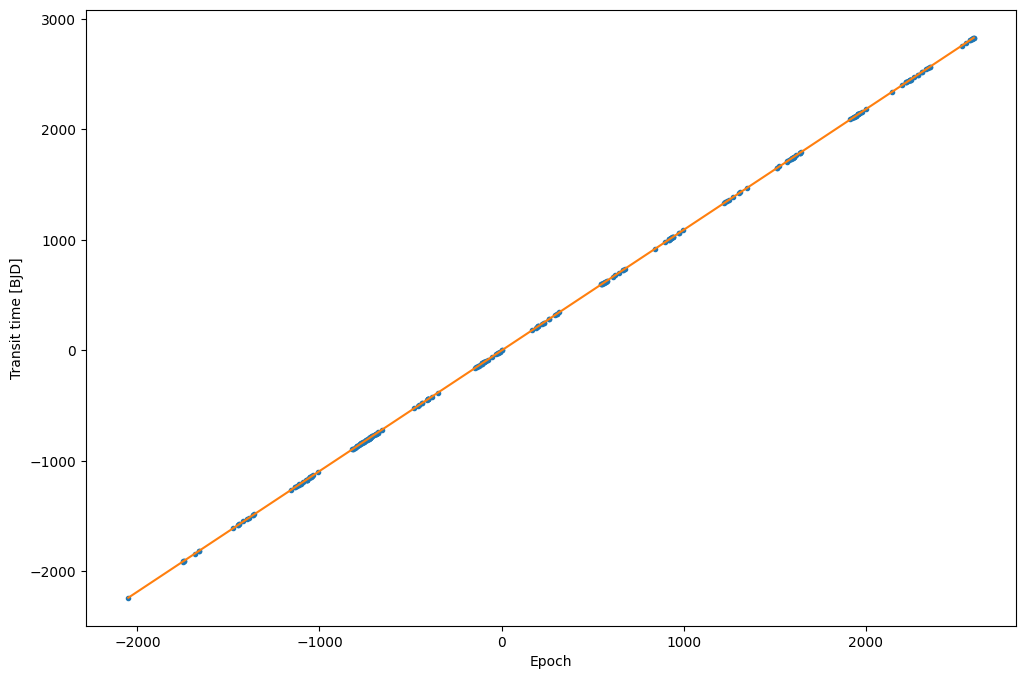

Average error [s] 75.68236575875486


In [23]:
observations.plot(style=".", xlabel="Epoch", ylabel="Transit time [BJD]")

E = observations.index.values
plt.plot(E, model(E, const_T0, const_P0, 0))
plt.show()
print("Average error [s]", average_uncertainty*24*60*60)

In [6]:
def fit_analytical_posterior(observations, sd):
    # compute the analytical posterior of the observations
    E = observations.index.values.astype(np.float64)
    T = observations.values.astype(np.float64)
    N = len(E)

    a = E.sum()
    b = (E**2).sum()
    c = (E**3).sum()
    d = (E**4).sum()

    A = T.sum()
    B = (T*E).sum()
    C = (T*(E**2)).sum()

    N1 = a*c-b**2
    N2 = -(N*c-a*b)
    N3 = N*b-a**2
    DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)

    mu_2 = (N1*A+N2*B+N3*C)/DET
    mu_dP_dE = 2 * mu_2
    mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)
    
    var_2 = (N*b-(a**2))*(sd**2)/DET
    var_dP_dE = 4 * var_2
    var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2
    
    return mu_dP_dE_ms, var_dP_dE_ms

In [3]:
# Turner et al 2020 result:
-9.45e-10*24*60*60*1000

-0.081648

In [327]:
mu_dP_dE_ms, var_dP_dE_ms = fit_analytical_posterior(observations, sd=1/24/60/60)
mu_dP_dE_ms, var_dP_dE_ms

(-0.060865699455416915, 8.475621841007546e-09)

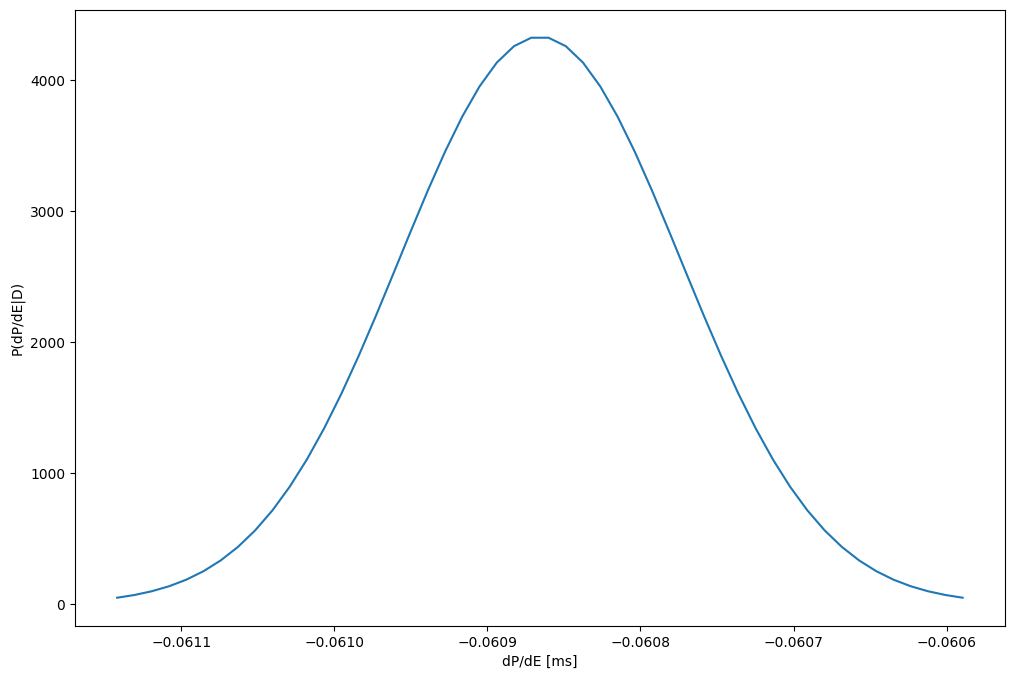

In [328]:
mu = mu_dP_dE_ms
sigma = np.sqrt(var_dP_dE_ms)
x = np.linspace(mu - 3*sigma, mu + 3*sigma)
plt.plot(x, sp.stats.norm.pdf(x, mu, sigma))
plt.xlabel("dP/dE [ms]")
plt.ylabel("P(dP/dE|D)")
plt.show()

#### Wasp-12b (MCMC)

In [330]:
sd = 1/24/60/60

def model(E, T0, P0, dP_dE):
    return T0 + P0*E + 0.5*(dP_dE/1000/60/60/24)*E**2

def log_likelihood(theta):
    T0, P0, dP_dE = theta
    
    N = len(observations.values)
    E = observations.index.values
    mu = model(E, T0, P0, dP_dE)

    log_likelihood = -(N/2 * np.log(2*sp.pi*(sd**2))) - (0.5 * np.nansum(((observations.values-mu)/sd)**2))
    return log_likelihood

def log_prior(theta):
    T0, P0, dP_dE = theta

    if P0 < 0:
        return -np.inf  # can't have negative periods
    return 0.0

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [332]:
def neg_log_likelihood(theta):
    return -log_likelihood(theta)

res = sp.optimize.minimize(neg_log_likelihood, (0.0, 1.0, 0.0), method="BFGS", tol=1e-6, options={'disp': True, "maxiter": 1e4})
res.x

         Current function value: 10412701.611307
         Iterations: 5
         Function evaluations: 200
         Gradient evaluations: 48


array([ 0.00379802,  1.09141995, -0.05971825])

In [333]:
pos = res.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
print("nwalkers", nwalkers, "ndim", ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 5000, progress=True);

nwalkers 32 ndim 3


100%|██████████████████████████████████████| 5000/5000 [00:11<00:00, 450.51it/s]


Text(0.5, 0, 'Step number')

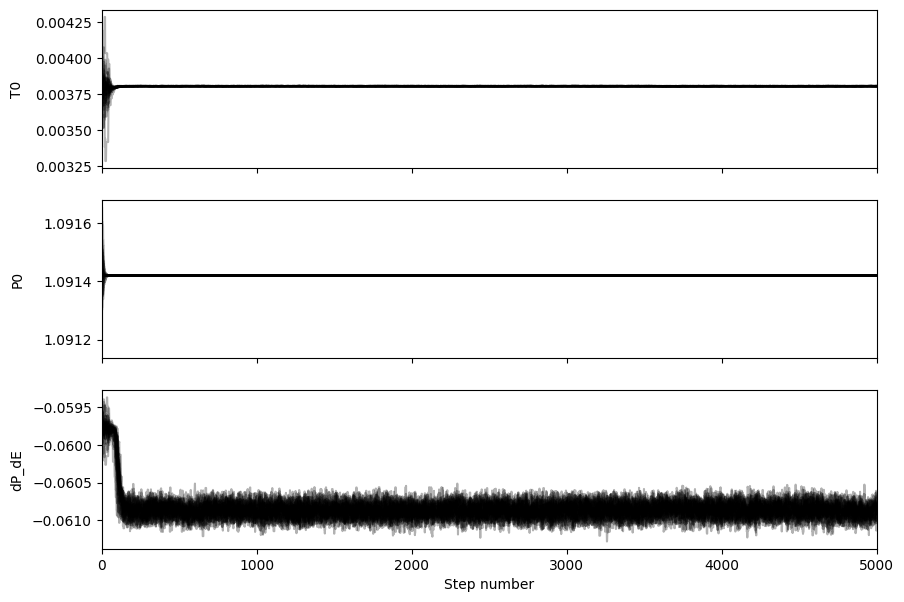

In [334]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["T0", "P0", "dP_dE"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")

In [335]:
tau = sampler.get_autocorr_time()
tau

array([26.76473015, 10.94170735, 95.66054926])

In [336]:
flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)
print(flat_samples.shape)

(5216, 3)


In [337]:
samples = sampler.get_chain(discard=0, thin=1, flat=True)[:,2]
means = []
variances = []
for i in tqdm(range(1, len(samples), 30)):
    subslice = samples[:i]
    mean = np.mean(subslice)
    means.append((i, mean))
    variance = np.var(subslice)
    variances.append((i, variance))
means = np.array(means)
variances = np.array(variances)

100%|█████████████████████████████████████| 5334/5334 [00:02<00:00, 2378.27it/s]


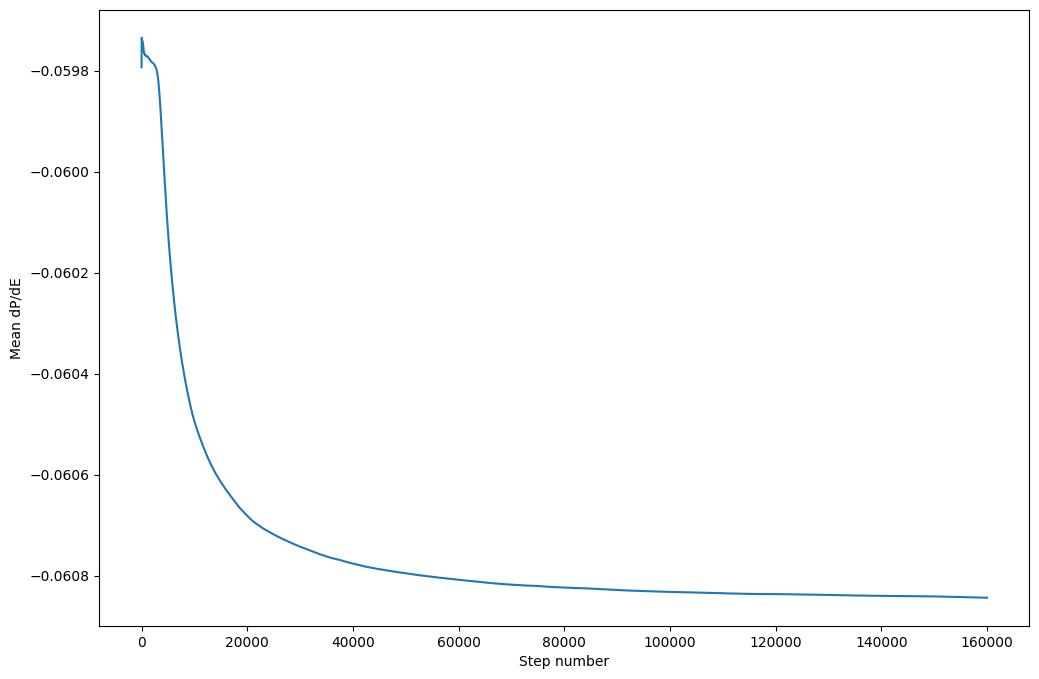

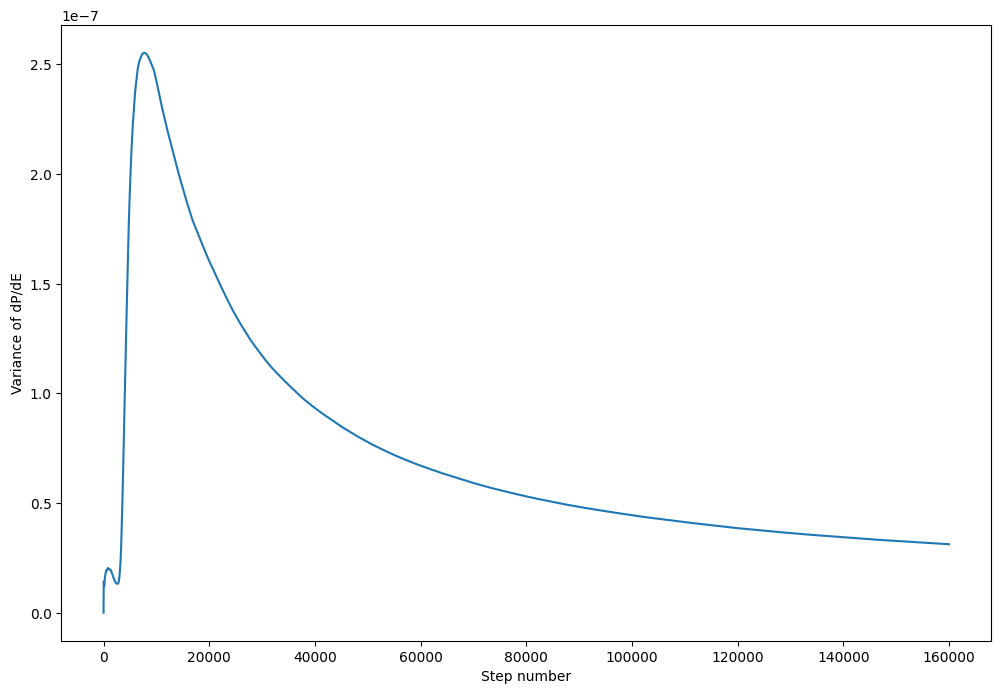

In [338]:
plt.plot(means[:,0], means[:,1])
plt.ylabel("Mean dP/dE")
plt.xlabel("Step number")
plt.show()

plt.plot(variances[:,0], variances[:,1])
plt.ylabel("Variance of dP/dE")
plt.xlabel("Step number")
plt.show()

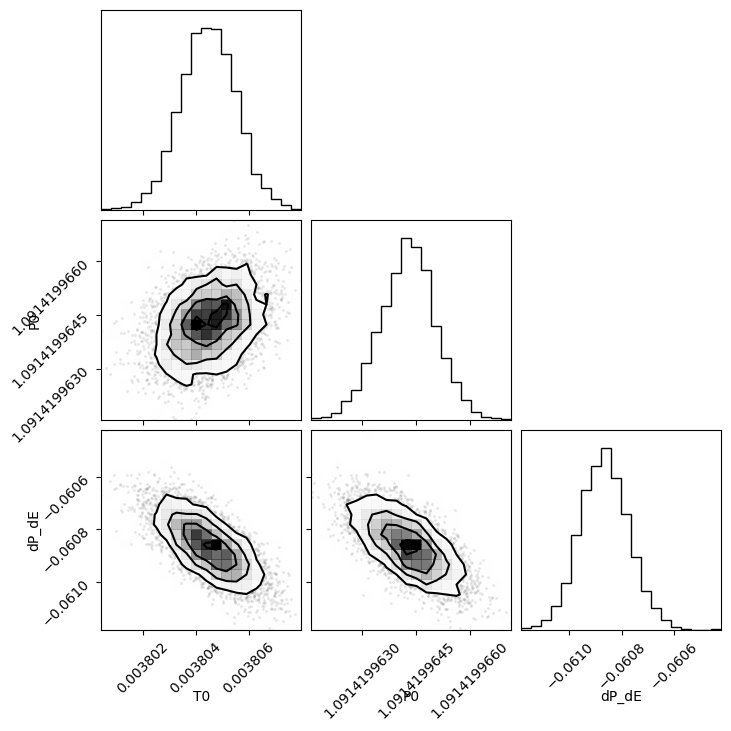

In [339]:
fig = corner.corner(
    flat_samples, labels=labels
)

In [340]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "{3} = {0:.9f}_{{-{1:.9f}}}^{{{2:.9f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [341]:
# MAP values of decay model
T0 = np.percentile(flat_samples[:, 0], 50)
P0 = np.percentile(flat_samples[:, 1], 50)
dP_dE = np.percentile(flat_samples[:, 2], 50)
T0, P0, dP_dE

(0.0038044860429419652, 1.0914199642988915, -0.06086714894396133)

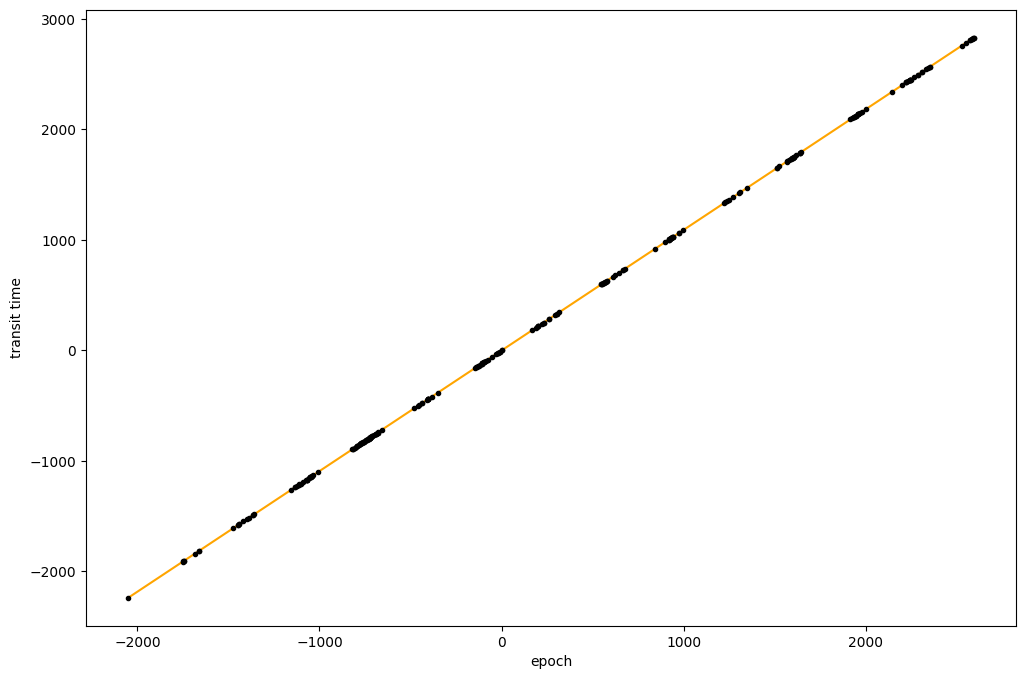

In [343]:
E = observations.index.values
y = model(E, T0, P0, dP_dE)
plt.plot(E, y, color="orange")
plt.errorbar(observations.index.values, observations.values, fmt=".k", capsize=0)
plt.xlabel("epoch")
plt.ylabel("transit time");
plt.show()

In [344]:
const_y = model(E, const_T0, const_P0, 0)
decay_y = model(E, T0, P0, dP_dE)

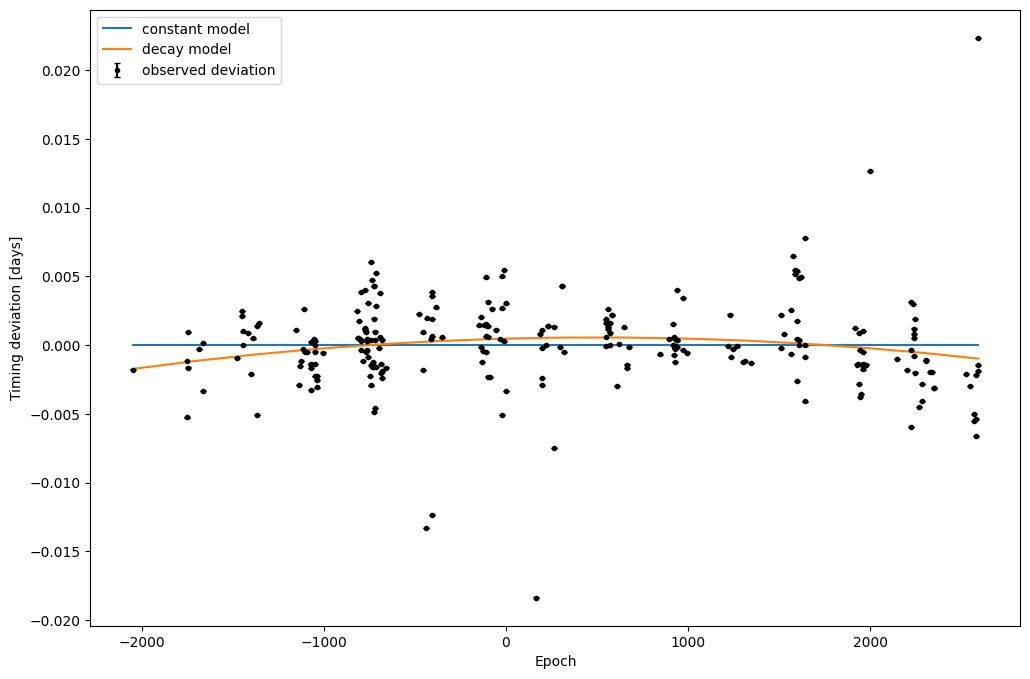

In [345]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=sd, fmt=".k", capsize=2, label="observed deviation")

deviation = decay_y - const_y
plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.plot(E, deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

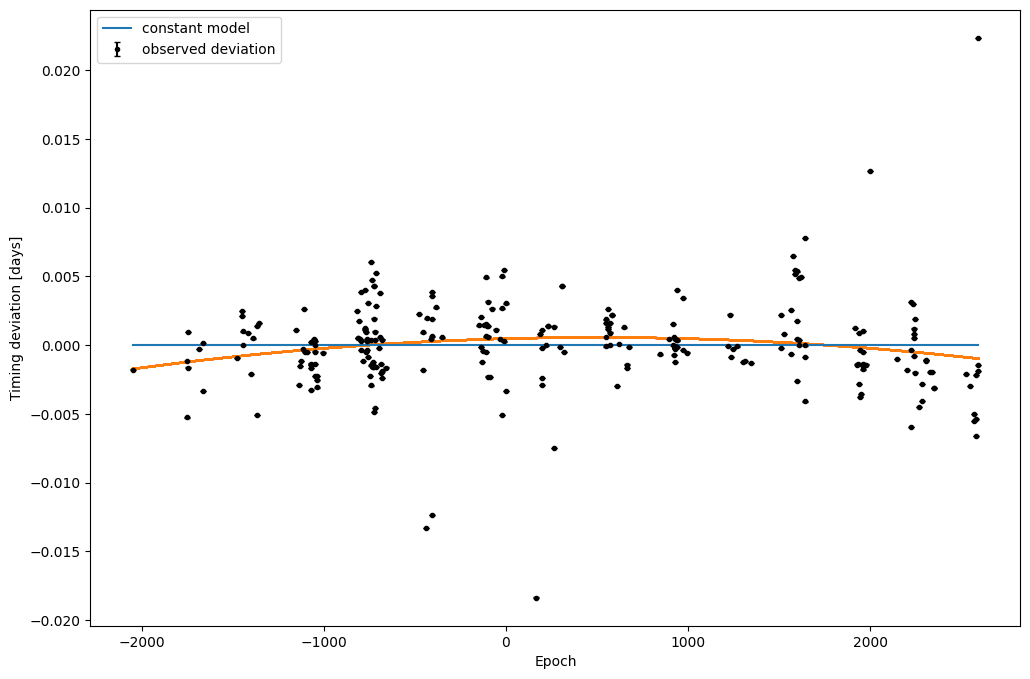

In [352]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=sd, fmt=".k", capsize=2, label="observed deviation")

inds = np.random.randint(len(flat_samples), size=250)
for ind in inds:
    sample = flat_samples[ind]
    T0, P0, dP_dE = sample
    deviation = model(E, T0, P0, dP_dE) - const_y
    plt.plot(E, deviation, "C1", alpha=0.05)

plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

#### All planets

Apply this technique (analytical and numerical) to generate posterior distributions over all planets for which we have ETD/exoclock transit data.

In [360]:
import glob
import re

files = glob.glob("./data/ORIGINALS/*.txt")

In [376]:
results = []

for f in tqdm(files):
    df = pd.read_csv(f, sep="\t", names=["index", "epoch", "transit time", "error", "data quality", "observer"])
    df["transit time"] = df["transit time"] - df["transit time"].quantile(0.5)
    df["epoch"] = df["epoch"] - df["epoch"].quantile(0.5)

    observations = df[["epoch", "transit time"]]
    observations = observations.set_index(df.epoch.astype(int))
    observations = observations["transit time"]
    average_uncertainty = df["error"].mean()

    mu_dP_dE_ms, var_dP_dE_ms = fit_analytical_posterior(observations, sd=average_uncertainty)
    name = re.search("ETD_(.*)_og.txt", f).group(1)
    prob_dP_dE_less_than_0 = sp.stats.norm.cdf(x=0, loc=mu_dP_dE_ms, scale=np.sqrt(var_dP_dE_ms))
    results.append([name, mu_dP_dE_ms, var_dP_dE_ms, prob_dP_dE_less_than_0])
    
results = pd.DataFrame(data=results, columns=["Planet", "Mean dP/dE [ms]", "Variance dP/dE [ms^2]", "Prob dP/dE < 0"])

100%|██████████████████████████████████████████| 71/71 [00:00<00:00, 167.87it/s]


In [379]:
results.sort_values(by="Prob dP/dE < 0", ascending=False)

,Planet,Mean dP/dE [ms],Variance dP/dE [ms^2],Prob dP/dE < 0
0,HAT-P-1,-101049.738919,1.784267e-01,1.000000e+00
15,WASP-12,-0.060866,4.854684e-05,1.000000e+00
69,GJ-1214,-113.767375,2.182017e-04,1.000000e+00
4,WASP-80,-992.413636,6.806860e-02,1.000000e+00
5,XO-1,-389.780395,1.199053e-02,1.000000e+00
67,TrES-2,-94.269890,9.966403e-04,1.000000e+00
57,WASP-33,-37.383470,3.328426e-01,1.000000e+00
56,HAT-P-6,-319.112320,5.766194e-02,1.000000e+00
44,WASP-93,-18.498557,2.175933e-01,1.000000e+00
10,XO-3,-100.713893,6.368912e-02,1.000000e+00


Text(0, 0.5, 'Transit time [BJD]')

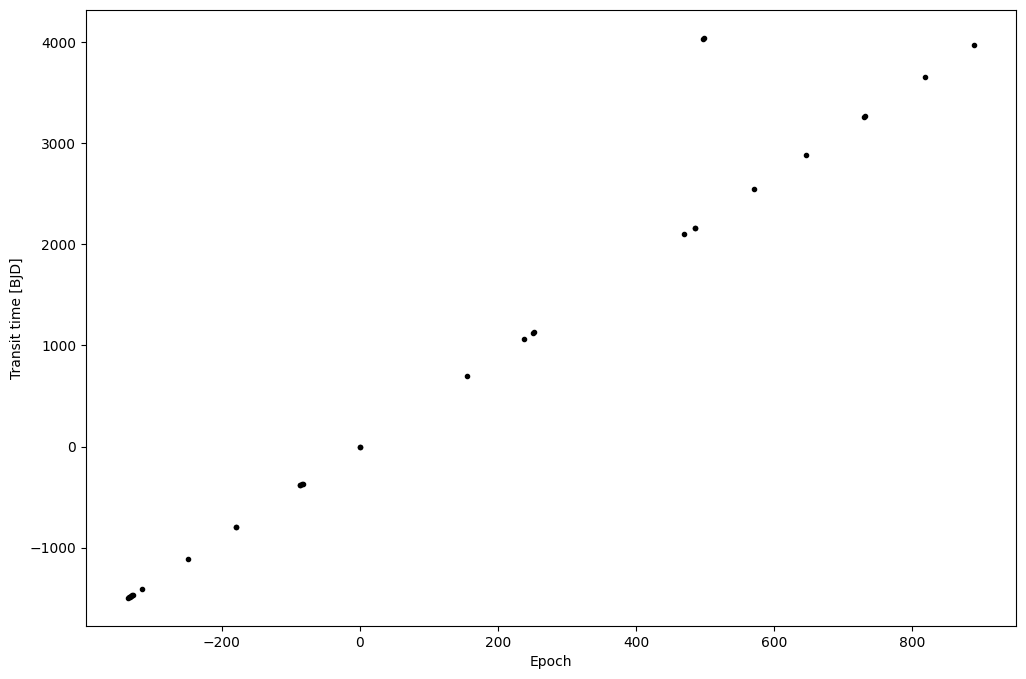

In [384]:
df = pd.read_csv("./data/ORIGINALS/ETD_HAT-P-1_og.txt", sep="\t", names=["index", "epoch", "transit time", "error", "data quality", "observer"])
df["transit time"] = df["transit time"] - df["transit time"].quantile(0.5)
df["epoch"] = df["epoch"] - df["epoch"].quantile(0.5)
plt.errorbar(df.epoch, df["transit time"], yerr=df.error, fmt=".k", capsize=0)
plt.xlabel("Epoch")
plt.ylabel("Transit time [BJD]")

In [383]:
df

,index,epoch,transit time,error,data quality,observer
0,1,-335.0,-1495.88024,0.00069,1,Lick observatory
1,2,-334.0,-1491.41172,0.00900,1,Bakos et al 2007
2,3,-333.0,-1486.94675,0.00076,1,Winn et al 2007
3,4,-331.0,-1478.01672,0.00054,1,Winn et al 2007
4,5,-331.0,-1478.01524,0.00047,1,Winn et al 2007
5,6,-329.0,-1469.08546,0.00059,1,Winn et al 2007
6,7,-328.0,-1464.62035,0.00107,1,Winn et al 2007
7,8,-315.0,-1406.57077,0.00290,1,Winn et al 2007
8,11,-249.0,-1111.86216,0.00072,1,Johnson et al 2008
9,12,-179.0,-799.29800,0.00184,3,Walter F.


In [390]:
observations = df[["epoch", "transit time"]]
observations = observations.set_index(df.epoch.astype(int))
observations = observations["transit time"].iloc[:-2]
average_uncertainty = df["error"].mean()

mu_dP_dE_ms, var_dP_dE_ms = fit_analytical_posterior(observations, sd=average_uncertainty)
prob_dP_dE_less_than_0 = sp.stats.norm.cdf(x=0, loc=mu_dP_dE_ms, scale=np.sqrt(var_dP_dE_ms))
mu_dP_dE_ms, var_dP_dE_ms, prob_dP_dE_less_than_0

(-0.21998281216347165, 0.1835937281297445, 0.6961658661641471)

### Including per-transit measurement uncertainty

Allow for varying measurement error per transit (both in numerical and analytical fits).

#### Wasp-12b (MCMC)

In [2]:
df = pd.read_csv("./data/ORIGINALS/ETD_WASP-12_og.txt", sep="\t", names=["index", "epoch", "transit time", "error", "data quality", "observer"])
df["transit time"] = df["transit time"] - df["transit time"].quantile(0.5)
df["epoch"] = df["epoch"] - df["epoch"].quantile(0.5)

In [3]:
observations = df[["epoch", "transit time"]]
observations = observations.set_index(df.epoch.astype(int))
observations = observations["transit time"]
error = df["error"].values

In [4]:
def model(E, T0, P0, dP_dE):
    return T0 + P0*E + 0.5*(dP_dE/1000/60/60/24)*E**2

def log_likelihood(theta):
    T0, P0, dP_dE = theta
    
    N = len(observations.values)
    E = observations.index.values
    mu = model(E, T0, P0, dP_dE)
    
    diff = observations.values - mu
    log_likelihood = -(0.5*N*np.log(2*np.pi)) -(np.sum(np.log(error))) -(0.5*diff@((1/np.power(error, 2))*diff))

    return log_likelihood

def log_prior(theta):
    T0, P0, dP_dE = theta

    if P0 < 0:
        return -np.inf  # can't have negative periods
    return 0.0

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [5]:
def neg_log_likelihood(theta):
    return -log_likelihood(theta)

res = sp.optimize.minimize(neg_log_likelihood, (0.0, 1.0, 0.0), method="BFGS", tol=1e-6, options={'disp': True, "maxiter": 1e4})
res.x

         Current function value: 457.606760
         Iterations: 5
         Function evaluations: 228
         Gradient evaluations: 54


array([ 0.00425659,  1.09141965, -0.06836524])

In [6]:
pos = res.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
print("nwalkers", nwalkers, "ndim", ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 5000, progress=True);

nwalkers 32 ndim 3


100%|██████████████████████████████████████| 5000/5000 [00:12<00:00, 407.38it/s]


Text(0.5, 0, 'Step number')

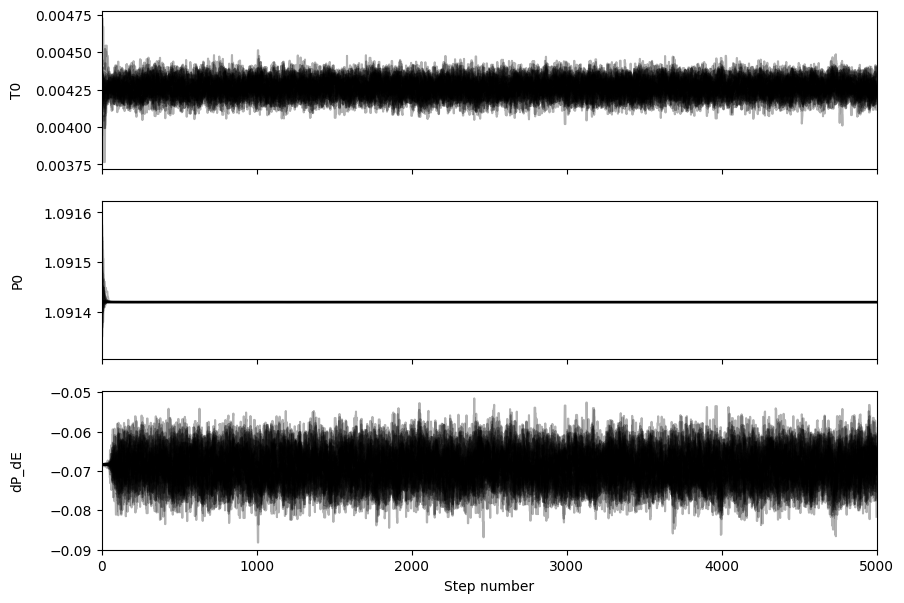

In [7]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["T0", "P0", "dP_dE"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")

In [8]:
tau = sampler.get_autocorr_time()
tau

array([36.76306251, 11.83688503, 36.48332057])

In [9]:
flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)
print(flat_samples.shape)

(5216, 3)


In [10]:
samples = sampler.get_chain(discard=0, thin=1, flat=True)[:,2]
means = []
variances = []
for i in tqdm(range(1, len(samples), 30)):
    subslice = samples[:i]
    mean = np.mean(subslice)
    means.append((i, mean))
    variance = np.var(subslice)
    variances.append((i, variance))
means = np.array(means)
variances = np.array(variances)

100%|█████████████████████████████████████| 5334/5334 [00:02<00:00, 2251.96it/s]


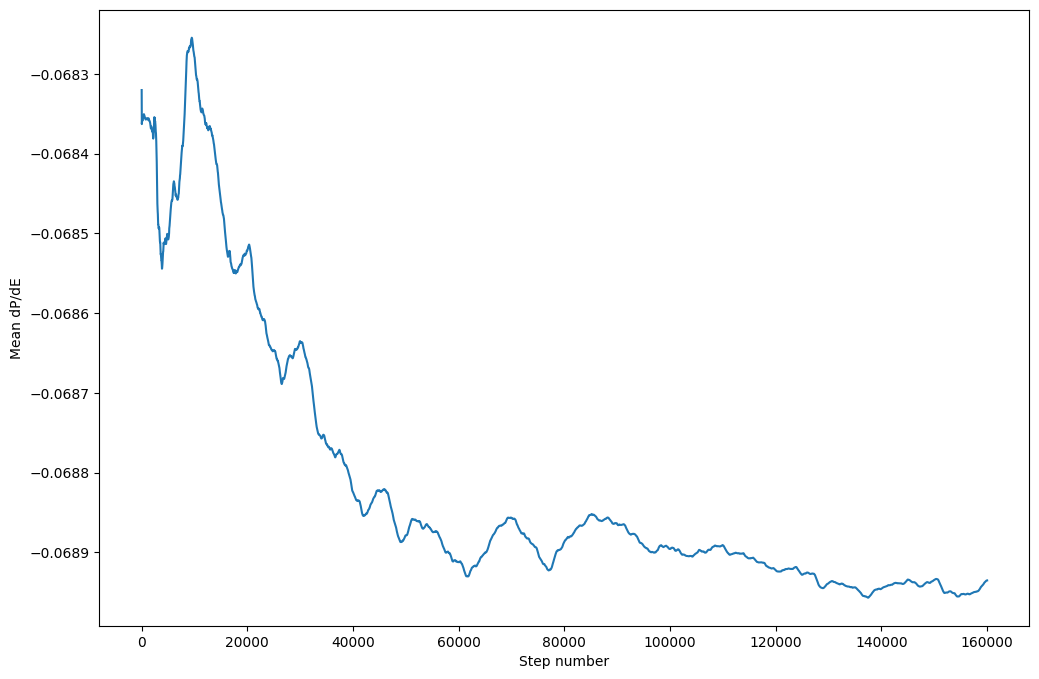

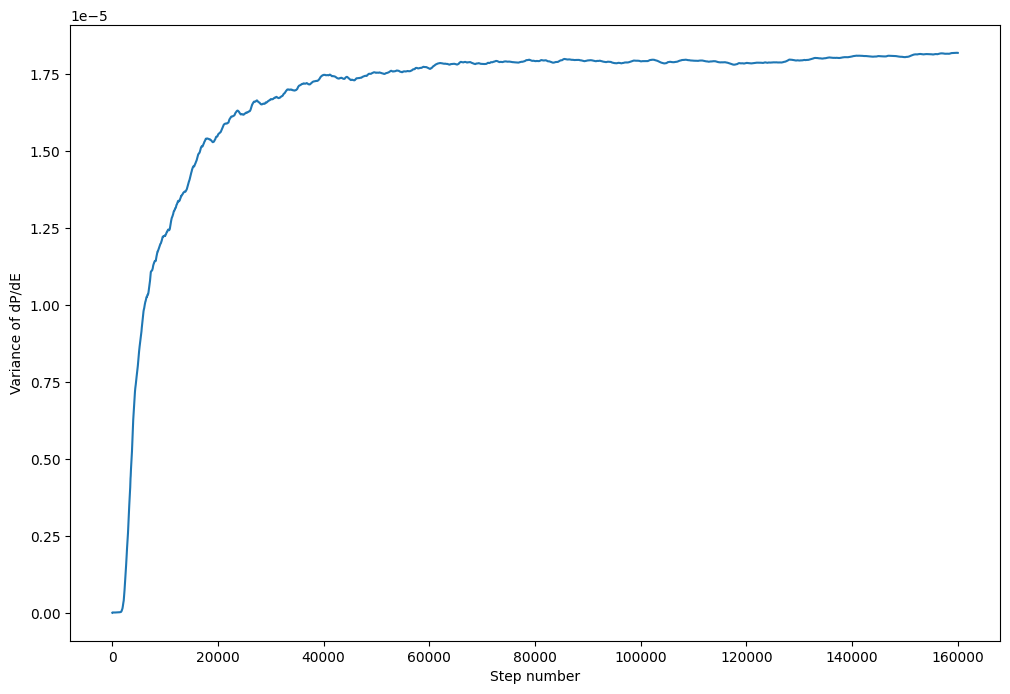

In [11]:
plt.plot(means[:,0], means[:,1])
plt.ylabel("Mean dP/dE")
plt.xlabel("Step number")
plt.show()

plt.plot(variances[:,0], variances[:,1])
plt.ylabel("Variance of dP/dE")
plt.xlabel("Step number")
plt.show()

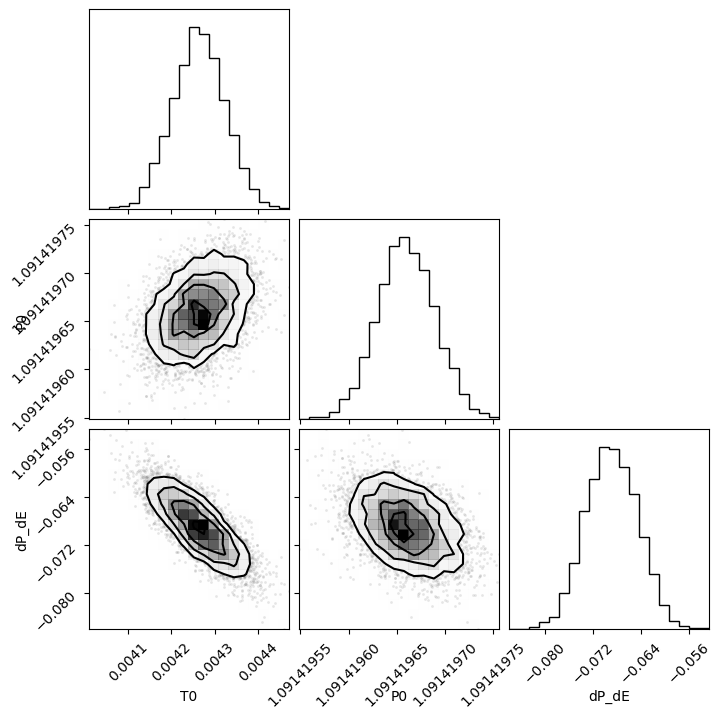

In [12]:
fig = corner.corner(
    flat_samples, labels=labels
)

In [13]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "{3} = {0:.9f}_{{-{1:.9f}}}^{{{2:.9f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
# MAP values of decay model
T0 = np.percentile(flat_samples[:, 0], 50)
P0 = np.percentile(flat_samples[:, 1], 50)
dP_dE = np.percentile(flat_samples[:, 2], 50)
T0, P0, dP_dE

(0.004263259618619255, 1.091419659145052, -0.06894376450752848)

In [20]:
sp.stats.norm.fit(flat_samples[:, 2])

(-0.0688881381228356, 0.004321401629229922)

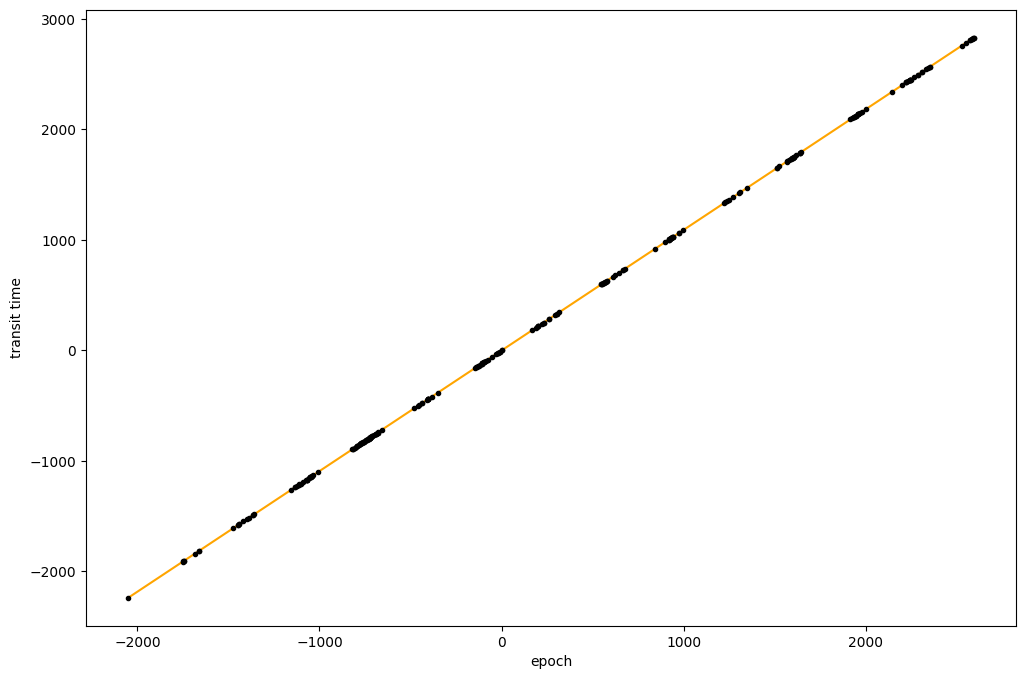

In [15]:
E = observations.index.values
y = model(E, T0, P0, dP_dE)
plt.plot(E, y, color="orange")
plt.errorbar(observations.index.values, observations.values, fmt=".k", capsize=0)
plt.xlabel("epoch")
plt.ylabel("transit time");
plt.show()

In [16]:
# ML values of constant model
E = observations.index.values
N = len(observations.values)

def const_log_likelihood(theta):
    T0, P0 = theta
    
    N = len(observations.values)
    E = observations.index.values
    mu = model(E, T0, P0, dP_dE=0)
    
    diff = observations.values - mu
    log_likelihood = -(0.5*N*np.log(2*np.pi)) -(0.5*np.log(np.dot(error, error))) -(0.5*diff@((1/np.power(error, 2))*diff))

    return log_likelihood


def const_neg_log_likelihood(theta):
    return -const_log_likelihood(theta)

const_res = sp.optimize.minimize(const_neg_log_likelihood, (0.0, 1.0), method="BFGS", options={'disp': True, "maxiter": 1e4})
const_T0, const_P0 = const_res.x
const_T0, const_P0

         Current function value: 2420.852465
         Iterations: 4
         Function evaluations: 117
         Gradient evaluations: 39


(0.003509120175883083, 1.0914194561558097)

In [17]:
const_y = model(E, const_T0, const_P0, 0)
decay_y = model(E, T0, P0, dP_dE)

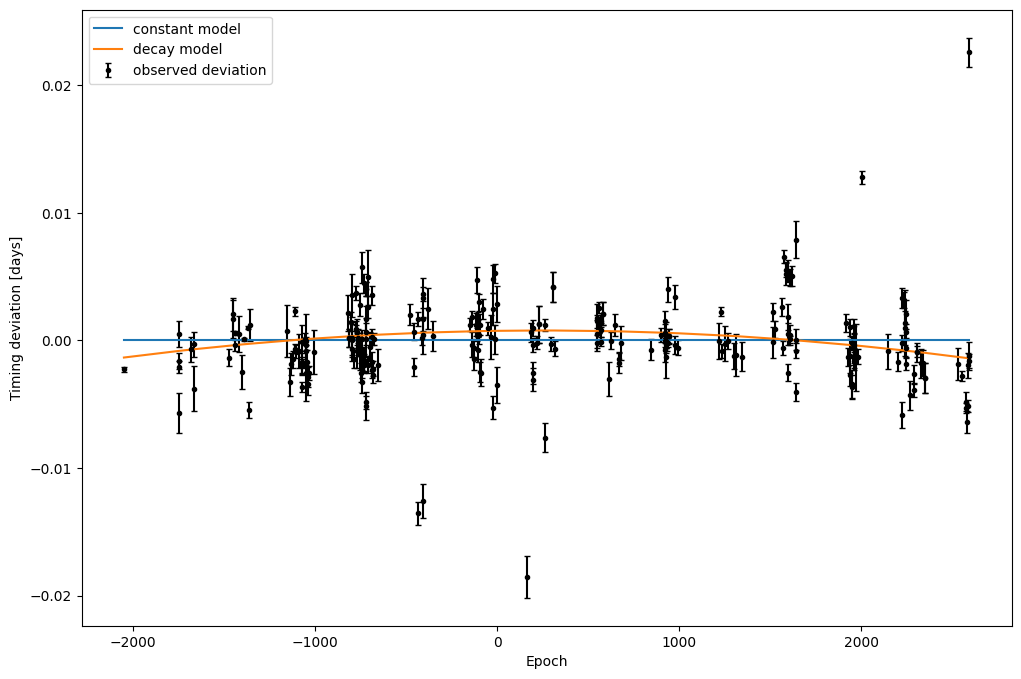

In [18]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=error, fmt=".k", capsize=2, label="observed deviation")

deviation = decay_y - const_y
plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.plot(E, deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

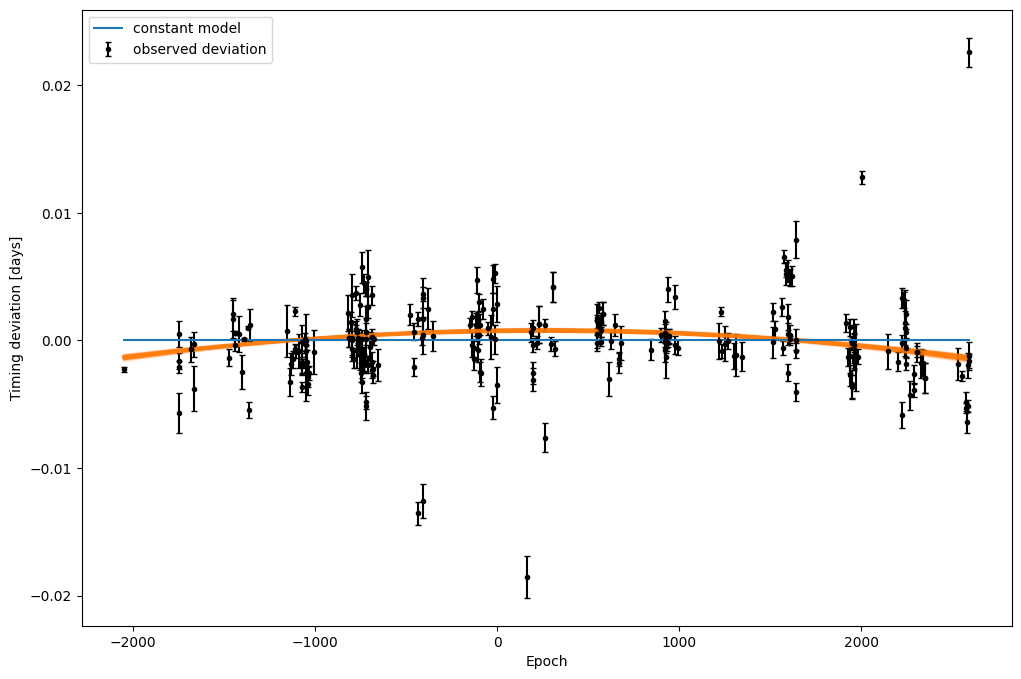

In [19]:
observed_deviation = observations.values - const_y
plt.errorbar(E, observed_deviation, yerr=error, fmt=".k", capsize=2, label="observed deviation")

inds = np.random.randint(len(flat_samples), size=250)
for ind in inds:
    sample = flat_samples[ind]
    T0, P0, dP_dE = sample
    deviation = model(E, T0, P0, dP_dE) - const_y
    plt.plot(E, deviation, "C1", alpha=0.05)

plt.plot(E, np.full(deviation.shape, 0), label="constant model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

#### Wasp-12b (Analytical)

In [9]:
def fit_analytical_posterior(observations, sd):
    # compute the analytical posterior of the observations
    sd2 = np.power(sd, -2)
    E = observations.index.values.astype(np.float64)
    T = observations.values.astype(np.float64)
    N = sd2.sum()

    a = (sd2*E).sum()
    b = (sd2*(E**2)).sum()
    c = (sd2*((E**3))).sum()
    d = (sd2*((E**4))).sum()

    A = (sd2*T).sum()
    B = (sd2*T*E).sum()
    C = (sd2*T*(E**2)).sum()

    N1 = a*c-b**2
    N2 = -(N*c-a*b)
    N3 = N*b-a**2
    DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)
    
    mu_0 = (-d*b*A + (c**2)*A - a*c*C + (b**2)*C + d*a*B - b*B*c) / -DET
    var_0 = ((c**2)-d*b)/-DET
    
    mu_1 = (d*a*A - b*c*A - a*b*C + c*N*C + (b**2)*B - d*B*N) / -DET  # days
    var_1 =  ((b**2)-d*N)/-DET

    mu_2 = (N1*A+N2*B+N3*C)/DET
    mu_dP_dE = 2 * mu_2
    mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)
    
    var_2 = (N*b-(a**2))/DET  # good reason for this: must invert sigma^-1
    var_dP_dE = 4 * var_2
    var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2
    
    return mu_0, var_0, mu_1, var_1, mu_dP_dE_ms, var_dP_dE_ms

In [39]:
df = pd.read_csv("./data/ORIGINALS/ETD_WASP-12_og.txt", sep="\t", names=["index", "epoch", "transit time", "error", "data quality", "observer"])
df["transit time"] = df["transit time"] - df["transit time"].quantile(0.5)
df["epoch"] = df["epoch"] - df["epoch"].quantile(0.5)

observations = df[["epoch", "transit time"]]
observations = observations.set_index(df.epoch.astype(int))
observations = observations["transit time"]
error = df["error"].values

In [41]:
mu_T0, var_T0, mu_P, var_P, mu_dP_dE_ms, var_dP_dE_ms = fit_analytical_posterior(observations, sd=error)
mu_T0, var_T0, mu_P, var_P, mu_dP_dE_ms, var_dP_dE_ms

(0.0042629199106351085,
 3.514275596432287e-09,
 1.0914196598444261,
 8.917304166714222e-16,
 -0.06885770736033554,
 1.799968050136934e-05)

Note that using average uncertainty gave a posterior variance on dP/dE of 4.85e-05 which was more uncertain!

#### All planets

In [43]:
files = glob.glob("./data/ORIGINALS/*.txt")

results = []

for f in tqdm(files):
    df = pd.read_csv(f, sep="\t", names=["index", "epoch", "transit time", "error", "data quality", "observer"])
    df["transit time"] = df["transit time"] - df["transit time"].quantile(0.5)
    df["epoch"] = df["epoch"] - df["epoch"].quantile(0.5)

    observations = df[["epoch", "transit time"]]
    observations = observations.set_index(df.epoch.astype(int))
    observations = observations["transit time"]
    error = df["error"].values
    
    mu_T0, var_T0, mu_P, var_P, mu_dP_dE_ms, var_dP_dE_ms = fit_analytical_posterior(observations, sd=error)
    name = re.search("ETD_(.*)_og.txt", f).group(1)
    prob_dP_dE_less_than_0 = sp.stats.norm.cdf(x=0, loc=mu_dP_dE_ms, scale=np.sqrt(var_dP_dE_ms))
    results.append([name, mu_T0, var_T0, mu_P, var_P, mu_dP_dE_ms, var_dP_dE_ms, prob_dP_dE_less_than_0])
    
results = pd.DataFrame(data=results, columns=["Planet", "mu_T0", "var_T0", "mu_P", "var_P", "mu_dP_dE_ms", "var_dP_dE_ms", "Prob dP/dE < 0"])

results.sort_values(by="Prob dP/dE < 0", ascending=False)
results.to_csv("./results/5_analytical_fit_all_planets.csv")

100%|██████████████████████████████████████████| 71/71 [00:00<00:00, 148.49it/s]


In [44]:
pd.read_csv("./results/5_analytical_fit_all_planets.csv")

,Unnamed: 0,Planet,mu_T0,var_T0,mu_P,var_P,mu_dP_dE_ms,var_dP_dE_ms,Prob dP/dE < 0
0,0,HAT-P-1,235.134379,6.111216e-08,5.074676,3.063752e-13,-132581.084491,0.050214,1.000000e+00
1,1,KELT-16,0.083525,1.326441e-08,0.969754,3.970105e-14,21.304003,0.001573,0.000000e+00
2,2,WASP-10,-0.000907,3.542422e-09,3.092728,3.995549e-15,-0.204527,0.001022,1.000000e+00
3,3,KELT-1,0.001188,3.571771e-08,1.217495,1.553519e-14,-0.161865,0.000477,1.000000e+00
4,4,WASP-80,0.199101,4.128174e-09,3.076305,1.508002e-13,-1890.259258,0.023718,1.000000e+00
5,5,XO-1,0.143069,1.084662e-08,3.945278,2.151183e-14,-214.698295,0.003677,1.000000e+00
6,6,GJ-436,0.004034,1.328588e-08,2.643898,1.148405e-14,0.165607,0.001159,5.749907e-07
7,7,WASP-92,0.000603,3.682487e-08,2.174671,5.281610e-13,-0.446851,0.020491,9.991008e-01
8,8,HAT-P-10,0.002208,5.820922e-09,3.722489,3.523078e-14,0.579418,0.006747,8.682225e-13
9,9,HAT-P-36,-0.010354,6.254956e-09,1.327347,3.173691e-15,0.090657,0.000184,1.177380e-11


### Plotting the effect of transit count, transit spacing and measurement uncertainty

The analytical formula for dP/dE variance is:

$Var(\frac{dP}{dE}) = \frac{4(\sum{\sigma^{-2}}*(\sum{\sigma^{-2}E^2})-(\sum{\sigma^{-2}E})^2))}{\sum{\sigma^{-2}E^4}*(\sum{\sigma^{-2}}*\sum{\sigma^{-2}E^2}-(\sum{\sigma^{-2}E})^2)-(\sum{\sigma^{-2}E^2})^3+2\sum{\sigma^{-2}E}*\sum{\sigma^{-2}E^2}*\sum{\sigma^{-2}E^3}-\sum{\sigma^{-2}}*(\sum{\sigma^{-2}E^3})^2)}$

Note that the analytical formula for dP/dE variance is independent of the observed transit times. When fitting, let's also do a really simple form of outlier detection: remove observations whose transit time is 500 days off a constant period model.

In [2]:
def fit_const_linear_model(observations):
    # least squares
    a = np.array([np.ones(len(observations)), observations.index.values]).transpose()
    b = observations.values
    x, r, _, _ = sp.linalg.lstsq(a, b)
    lst_T0, lst_P0 = x[0], x[1]
    model_values = lst_T0 + lst_P0*observations.index.values
    residuals = observations.values - model_values
    return lst_T0, lst_P0, residuals

In [3]:
def fit_analytical_posterior_variance(E, sd):
    # compute the analytical posterior of the observations
    sd2 = np.power(np.float64(sd), -2)
    E = E.astype(np.float64)
    N = sd2.sum()

    a = (sd2*E).sum()
    b = (sd2*(E**2)).sum()
    c = (sd2*((E**3))).sum()
    d = (sd2*((E**4))).sum()

    DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)

    var_2 = (N*b-(a**2))/DET  # good reason for this: must invert sigma^-1
    var_dP_dE = 4 * var_2
    var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2
    
    return var_dP_dE_ms

In [4]:
fit_analytical_posterior_variance(np.arange(1000*10, step=10), sd=1000/1000/60/60/24)

2.706202084024541e-11

In [10]:
files = glob.glob("./data/ORIGINALS/*.txt")

planets = []

for f in tqdm(files):
    df = pd.read_csv(f, sep="\t", names=["index", "epoch", "transit time", "error", "data quality", "observer"])

    transit_count = len(df)
    median_spacing = df["epoch"].diff(1).median()
    median_error_seconds = df["error"].median() * 24 * 60 * 60
    
    observations = df[["epoch", "transit time"]]
    observations = observations.set_index(df.epoch.astype(int))
    observations = observations["transit time"]
    error = df["error"].values
    
    # remove outliers that are more than 500 days off from the constant period model
    _, _, residuals = fit_const_linear_model(observations)
    mask = np.where(residuals < 500, True, False)
    masked_observations = observations[mask]
    masked_error = error[mask]
    mu_0, var_0, mu_1, var_1, posterior_decay_rate_mean, posterior_decay_rate_variance = fit_analytical_posterior(masked_observations, sd=masked_error)
    prob_dP_dE_less_than_0 = sp.stats.norm.cdf(x=0, loc=posterior_decay_rate_mean, scale=np.sqrt(posterior_decay_rate_variance))

    name = re.search("ETD_(.*)_og.txt", f).group(1)
    planets.append([name, transit_count, median_spacing, median_error_seconds, posterior_decay_rate_mean, posterior_decay_rate_variance, prob_dP_dE_less_than_0])
    
planets = pd.DataFrame(data=planets, columns=["Planet", "transit_count", "median_spacing", "median_error_seconds", "posterior_decay_rate_mean", "posterior_decay_rate_variance", "prob_dP_dE_less_than_0"])
planets.head()

100%|██████████████████████████████████████████| 71/71 [00:00<00:00, 164.38it/s]


,Planet,transit_count,median_spacing,median_error_seconds,posterior_decay_rate_mean,posterior_decay_rate_variance,prob_dP_dE_less_than_0
0,HAT-P-1,32,2.0,92.448,-0.089393,0.051856,0.652677
1,KELT-16,66,2.0,73.440,-0.245354,0.001571,1.000000
2,WASP-10,174,1.0,50.544,-0.204527,0.001022,1.000000
3,KELT-1,54,14.0,83.376,-0.161864,0.000477,1.000000
4,WASP-80,56,1.0,42.336,-0.007121,0.023577,0.518494


In [11]:
transit_counts = np.unique(np.logspace(np.log10(3), np.log10(planets.transit_count.max()), num=20, base=10, dtype=np.int64))
transit_spacings = np.unique(np.logspace(0.0, np.log10(planets.median_spacing.max()), num=20, base=10, dtype=np.int64))
measurement_uncertainties = np.unique(np.logspace(np.log10(planets.median_error_seconds.min()), np.log10(planets.median_error_seconds.max()), num=20, base=10, dtype=np.float64)) # seconds
index = pd.MultiIndex.from_product(iterables=[transit_counts, transit_spacings, measurement_uncertainties, [None], [None]], names=["transit_count", "transit_spacing", "measurement_unc", "planet", "prob_dP_dE_less_than_0"]).union(pd.MultiIndex.from_arrays(arrays=[planets.transit_count, planets.median_spacing, planets.median_error_seconds, planets.Planet, planets.prob_dP_dE_less_than_0], names=["transit_count", "transit_spacing", "measurement_unc", "planet", "prob_dP_dE_less_than_0"]))
df = pd.DataFrame(index=index, columns=["decay_rate_variance"]).reset_index()
df.head()

,transit_count,transit_spacing,measurement_unc,planet,prob_dP_dE_less_than_0,decay_rate_variance
0,3,1.0,10.368000,NaN,NaN,NaN
1,3,1.0,11.850314,NaN,NaN,NaN
2,3,1.0,13.544554,NaN,NaN,NaN
3,3,1.0,15.481020,NaN,NaN,NaN
4,3,1.0,17.694342,NaN,NaN,NaN


In [12]:
for i, row in tqdm(df.iterrows()):
    E = np.arange(row.transit_count*row.transit_spacing, step=row.transit_spacing)
    df.at[i, "decay_rate_variance"] = fit_analytical_posterior_variance(E, sd=row.measurement_unc/60/60/24)

df.decay_rate_variance = df.decay_rate_variance.astype(np.float64)
df["log_decay_rate_variance"] = np.log10(df.decay_rate_variance)
df.planet = df.planet.fillna(value="NA")
df.loc[:, "marker_size"] = 1
df.loc[df.prob_dP_dE_less_than_0.notna(), "marker_size"] = (df.prob_dP_dE_less_than_0 * 10).clip(1, 10)

5391it [00:01, 3476.98it/s]


In [14]:
# df.to_csv("./results/5_observational_parameters_effect.csv")

In [18]:
df.planet.iloc[0]

'NA'

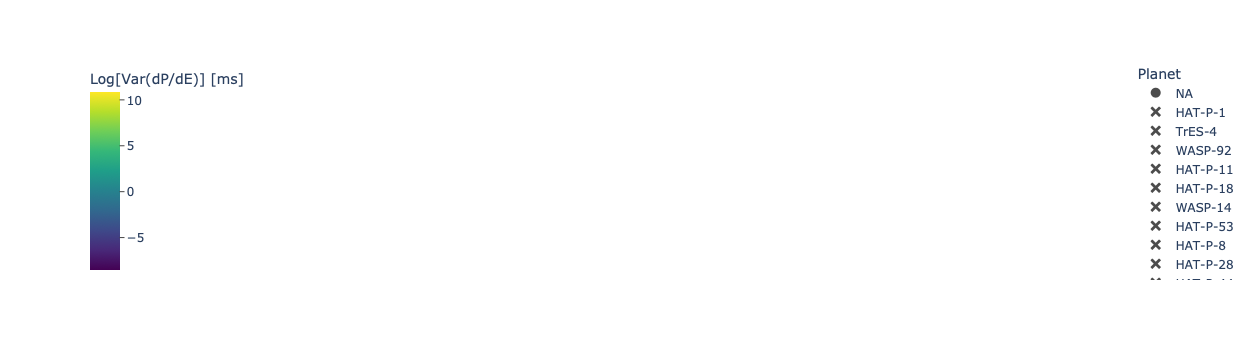

In [16]:
labels = {"measurement_unc": "Measurement uncertainty [s]", "transit_spacing": "Transit spacing", "transit_count": "Transit count", "planet": "Planet", "log_decay_rate_variance": "Log[Var(dP/dE)] [ms]"}
fig = px.scatter_3d(df, x="transit_count", y="transit_spacing", z="measurement_unc", symbol="planet", size="marker_size", symbol_map={"NA": "circle"}, symbol_sequence=["x"], color="log_decay_rate_variance", color_continuous_scale=px.colors.sequential.Viridis, log_x=True, log_y=True, log_z=True, labels=labels, height=1000)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.show()

This gives us a heatmap describing the general trend in posterior decay rate variance given transit count, spacing and measurement uncertainty. Planets have been highlighted as crosses and placed according to median transit spacing and measurement uncertainty. The size of the cross is proportional to the probability of decay. Visualising probability of decay more specifically:

In [34]:
planets.head()

,Planet,transit_count,median_spacing,median_error_seconds,posterior_decay_rate_mean,posterior_decay_rate_variance,prob_dP_dE_less_than_0
0,HAT-P-1,32,2.0,92.448,-0.089393,0.051856,0.652677
1,KELT-16,66,2.0,73.440,-0.245354,0.001571,1.000000
2,WASP-10,174,1.0,50.544,-0.204527,0.001022,1.000000
3,KELT-1,54,14.0,83.376,-0.161864,0.000477,1.000000
4,WASP-80,56,1.0,42.336,-0.007121,0.023577,0.518494


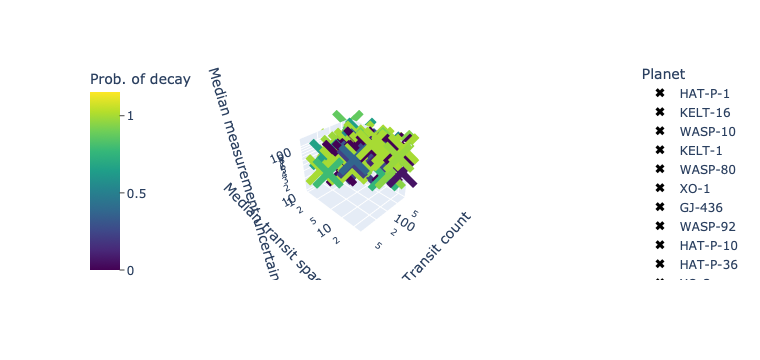

In [19]:
labels = {"prob_dP_dE_less_than_0": "Prob. of decay", "median_spacing": "Median transit spacing", "transit_count": "Transit count", "median_error_seconds": "Median measurement uncertainty [s]"}
fig = px.scatter_3d(planets, x="transit_count", y="median_spacing", z="median_error_seconds", symbol="Planet", symbol_sequence=["x"], color="prob_dP_dE_less_than_0", color_continuous_scale=px.colors.sequential.Viridis, log_x=True, log_y=True, log_z=True, labels=labels, height=1000)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.show()

Let's plot probability of decay vs posterior variance:

<AxesSubplot: xlabel='Probability of decay < 0', ylabel='Posterior Var(dP/dE) [ms]'>

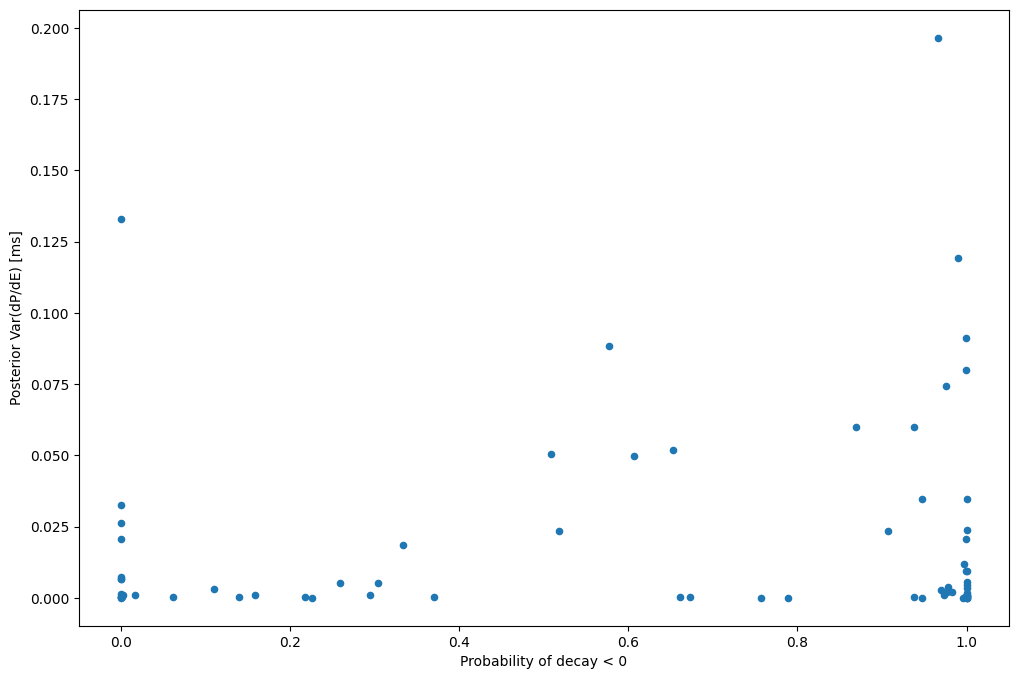

In [351]:
planets.plot.scatter(x="prob_dP_dE_less_than_0", y="posterior_decay_rate_variance", xlabel="Probability of decay rate < 0", ylabel="Posterior Var(dP/dE) [ms]")

In [ ]:
T0 + Po*E + 0.5*dp/dE*E^2

Question: The method can be quite susceptible to outliers. How can we best handle this? Filter out all points which are more than x standard deviations away from a constant period model i.e. assume that any decay won't be more than certain value?

#### Closed form formulas for the effect of transit count, spacing and measurement uncertainty on posterior decay rate variance

Closed form approximate formulas that describe how posterior variance changes with number of transits, spacing of transits, measurement uncertainty and prior variance. Compute closed form solutions (Taylor expanded if necessary) for the effect of the following on posterior dP/dE variance:

Posterior variance by transit count:

$Var(N) = \frac{720 N^2}{10 + 90 N + 340 N^2 + 714 N^3 + 910 N^4 + 735 N^5 + 360 N^6 + 81 N^7}\sigma^2$

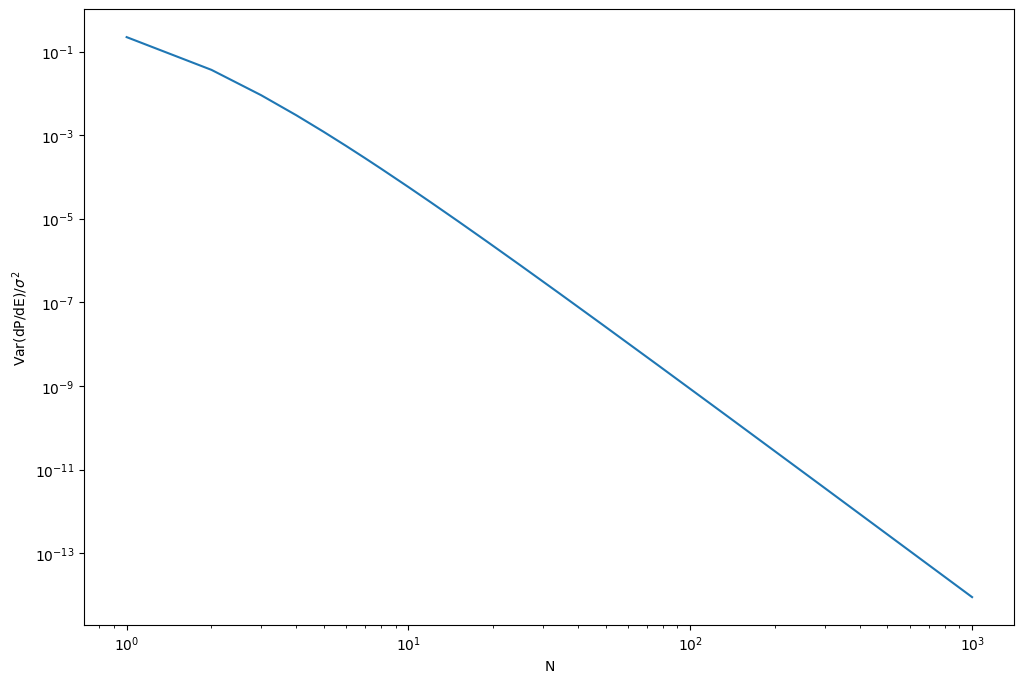

In [33]:
N = np.arange(1.0, 1000.0)
sd = 1
V = (720*np.power(N, 2))/(10 + 90*N + 340*np.power(N, 2) + 714*np.power(N, 3) + 910*np.power(N, 4) + 735*np.power(N, 5) + 360*np.power(N, 6) + 81*np.power(N, 7))

plt.plot(N, V)
plt.xlabel("N")
plt.ylabel("Var(dP/dE)/$\sigma^2$")
plt.yscale("log")
plt.xscale("log")

Posterior variance by measurement uncertainty:

$Var(N) \propto \sigma^2$

Text(0, 0.5, 'Var(dP/dE) [days^2]')

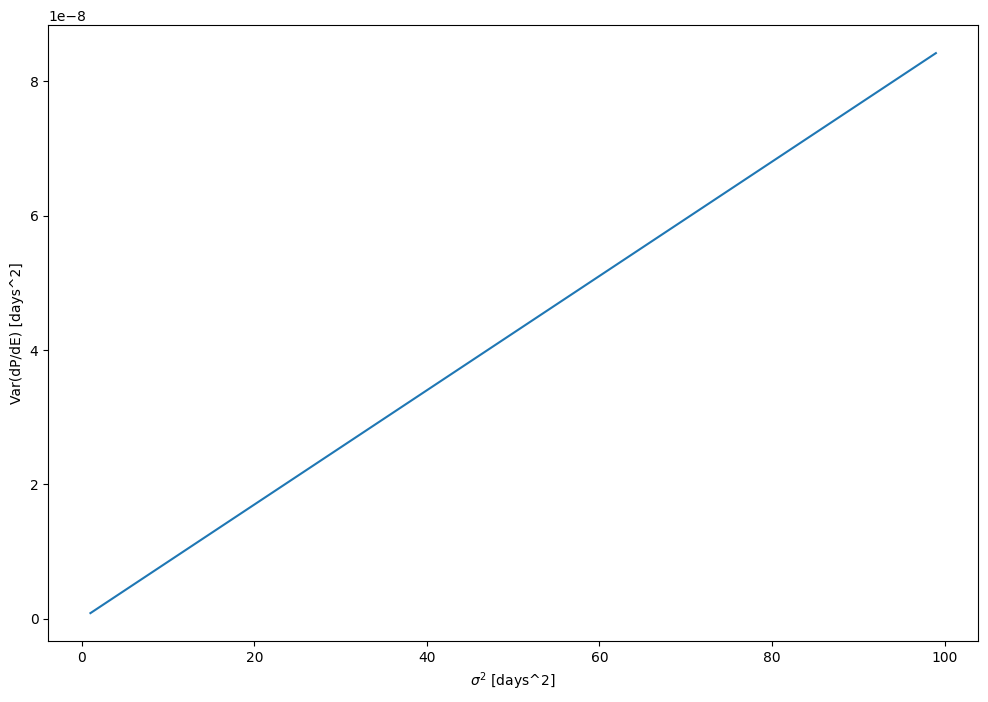

In [37]:
N = 100
sd2 = np.arange(1.0, 100.0)
V = sd2*(720*np.power(N, 2))/(10 + 90*N + 340*np.power(N, 2) + 714*np.power(N, 3) + 910*np.power(N, 4) + 735*np.power(N, 5) + 360*np.power(N, 6) + 81*np.power(N, 7))

plt.plot(sd2, V)
plt.xlabel("$\sigma^2$ [days^2]")
plt.ylabel("Var(dP/dE) [days^2]")
# plt.yscale("log")
# plt.xscale("log")

Posterior variance by transit spacing. In this case the summation has an extra term P for spacing, which behaves similary to the $\sigma^{-2}$ term for measurement uncertainty.

$Var(N) \propto P^{-1}$

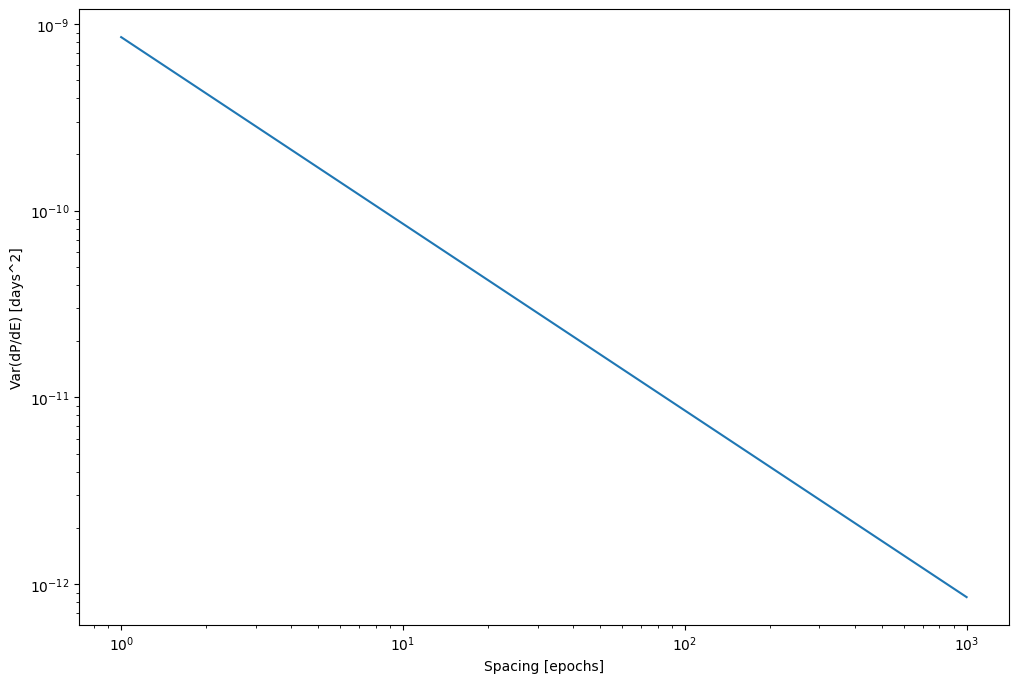

In [39]:
N = 100
sd2 = 1
P = np.arange(1.0, 1000.0)
V = (sd2/P)*(720*np.power(N, 2))/(10 + 90*N + 340*np.power(N, 2) + 714*np.power(N, 3) + 910*np.power(N, 4) + 735*np.power(N, 5) + 360*np.power(N, 6) + 81*np.power(N, 7))

plt.plot(P, V)
plt.xlabel("Spacing [epochs]")
plt.ylabel("Var(dP/dE) [days^2]")
plt.yscale("log")
plt.xscale("log")

### Comparison with Turner's 2020 analysis

In [8]:
def fit_analytical_posterior(observations, sd):
    # compute the analytical posterior of the observations
    sd2 = np.power(sd, -2)
    E = observations.index.values.astype(np.float64)
    T = observations.values.astype(np.float64)
    N = sd2.sum()

    a = (sd2*E).sum()
    b = (sd2*(E**2)).sum()
    c = (sd2*((E**3))).sum()
    d = (sd2*((E**4))).sum()

    A = (sd2*T).sum()
    B = (sd2*T*E).sum()
    C = (sd2*T*(E**2)).sum()

    N1 = a*c-b**2
    N2 = -(N*c-a*b)
    N3 = N*b-a**2
    DET = (d*(N*b-a**2)-b**3+2*a*b*c-N*c**2)

    mu_2 = (N1*A+N2*B+N3*C)/DET
    mu_dP_dE = 2 * mu_2
    mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)
    
    var_2 = (N*b-(a**2))/DET  # good reason for this: must invert sigma^-1
    var_dP_dE = 4 * var_2
    var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2
    
    return mu_dP_dE_ms, var_dP_dE_ms

In [9]:
turner_df = pd.read_csv("./data/turner_2020.csv")
turner_df.head()

,type,transit_time,error,epoch,source
0,tra,2.454516e+06,0.00043,-1640,H09
1,occ,2.454769e+06,0.00080,-1408,Ca11
2,occ,2.454774e+06,0.00060,-1404,Ca11
3,tra,2.454836e+06,0.00028,-1346,C13
4,tra,2.454841e+06,0.00062,-1342,Ch11


In [10]:
turner_transits = turner_df[turner_df.type == "tra"]
turner_transits.head()

,type,transit_time,error,epoch,source
0,tra,2.454516e+06,0.00043,-1640,H09
3,tra,2.454836e+06,0.00028,-1346,C13
4,tra,2.454841e+06,0.00062,-1342,Ch11
5,tra,2.455141e+06,0.00042,-1067,C17
6,tra,2.455147e+06,0.00043,-1061,M13


In [11]:
observations = turner_transits.transit_time
observations.index = turner_transits.epoch
error = turner_transits.error

In [12]:
mu, var = fit_analytical_posterior(observations, sd=error)
sd = np.sqrt(var)
mu, sd

(-0.08274771004280762, 0.0048342547796094)

In [13]:
# Turner et al 2020 result:
turner_mu, turner_sd = -9.45e-10*24*60*60*1000, 4.7e-11*24*60*60*1000
turner_mu, turner_sd

(-0.081648, 0.0040608)

In [14]:
difference = mu-turner_mu
difference / turner_mu * 100

1.346891586821015

In [23]:
# difference in standard deviations from Turner's result
difference / turner_sd

-0.2708111807544381

In [24]:
# difference in standard deviations from my result
difference / sd

-0.22748284750032913

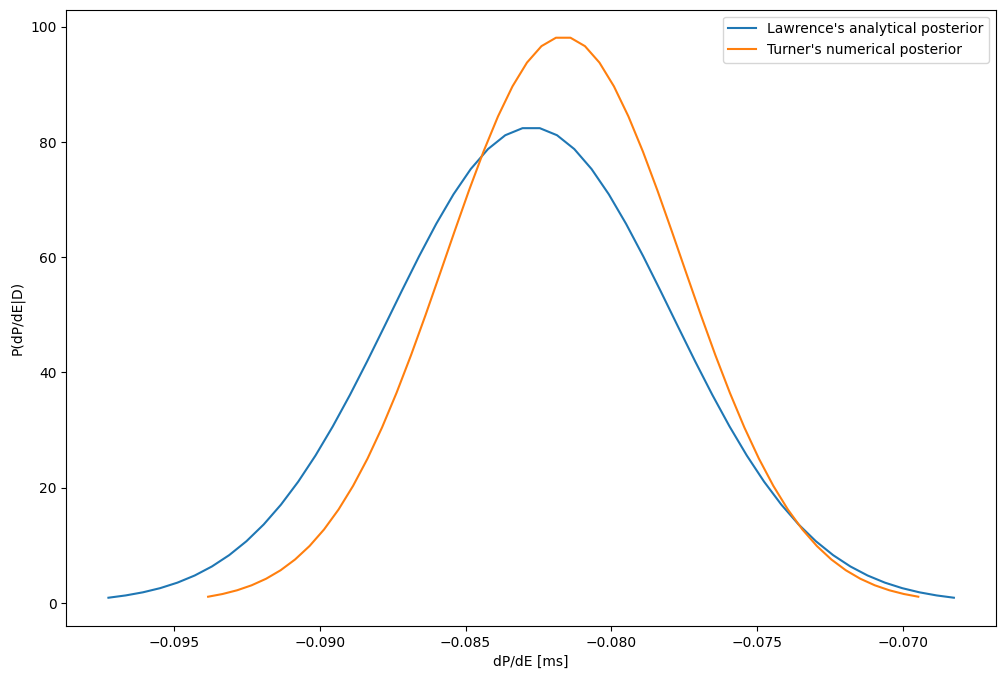

In [25]:
x = np.linspace(mu - 3*sd, mu + 3*sd)
plt.plot(x, sp.stats.norm.pdf(x, mu, sd), label="Lawrence's analytical posterior")
plt.xlabel("dP/dE [ms]")
plt.ylabel("P(dP/dE|D)")

x = np.linspace(turner_mu - 3*turner_sd, turner_mu + 3*turner_sd)
plt.plot(x, sp.stats.norm.pdf(x, turner_mu, turner_sd), label="Turner's numerical posterior")
plt.xlabel("dP/dE [ms]")
plt.ylabel("P(dP/dE|D)")
plt.legend()
plt.show()

My modelling technique 1.3% different from Turner 2020's result, using the same data as Turner. Well within the the 1 standard deviation of each other.

Note however that Turner also fitted occulations, which I have note. The occultation timings behave the same in a simple orbital decay model, they are just displaced by P/2 from the reference time T0. Let's try incorporating that into our formula.

Assuming the occultations are independent of transits, then we can resolve to get an analytical formula including occultations. The model goes from:

$P({T}|\Theta) \sim N(T_{0}+P_{0}E+\frac{1}{2}\frac{dP}{dE}E^2, {\sigma^2})$

to:

$P({T},{O}|\Theta) = P({T}|\Theta)*P({O}|\Theta) \sim N(T_{0}+P_{0}E+\frac{1}{2}\frac{dP}{dE}E^2, {\sigma^2})*N(T_{0}+\frac{1}{2}P_{0}E+\frac{1}{2}\frac{dP}{dE}E^2, {\sigma^2})$

Assuming the transit observations are independent of the occultation observations (we already assume that all observations are independent of each other). Completing this square is significantly more non-trivial.

In [30]:
def fit_analytical_posterior_with_occultations(transits, transit_sd, occults, occult_sd):
    # compute the analytical posterior of the observations
    tsd2 = np.power(transit_sd, -2)
    osd2 = np.power(occult_sd, -2)

    tE = transits.index.values.astype(np.float64)
    T = transits.values.astype(np.float64)
    tO = occults.index.values.astype(np.float64)
    O = occults.values.astype(np.float64)    
    
    
    A = tsd2.sum()
    B = (tsd2*tE).sum()
    C = (tsd2*(tE**2)).sum()
    D = (tsd2*((tE**3))).sum()
    E = (tsd2*((tE**4))).sum()

    a = osd2.sum()
    b = (osd2*tO).sum()
    c = (osd2*(tO**2)).sum()
    d = (osd2*((tO**3))).sum()
    e = (osd2*((tO**4))).sum()
    
    
    X = (tsd2*T).sum()
    Y = (tsd2*T*tE).sum()
    Z = (tsd2*T*(tE**2)).sum()

    x = (osd2*O).sum()
    y = (osd2*O*tO).sum()
    z = (osd2*O*(tO**2)).sum()


    mu_2 = ((-2*x - 2*X)* (2*a*d + 2*a*D - a*C + 4*b*d + 4*b*D - 2*b*c - 4*b*C + 4*B*d + 4*B*D + 2*B*c - 4*c**2 - 8*c*C - 4* C**2))/(-10.8731* a* A + 16* e* a* B + 8* a* d**2 + 16* a* d* D - 8* a* d* C + 8* a* D**2 - 8* a* D* C - 16* e* a* c + 2* a* C**2 - 16* e* a* C - 16* e* A* b + 8* A* d**2 + 16* A* d* D + 8* A* d* c + 8* A* D**2 + 8* A* D* c + 2* A* c**2 - 16* e* A* c - 16* e* A* C + 16* e* b**2 + 32* e* b* B - 16* b* d* c - 16* b* d* C - 16* b* D* c - 16* b* D* C + 8* b* c* C + 8* b* C**2 + 16* e* B**2 - 16* B* d* c - 16* B* d* C - 16* B* D* c - 16* B* D* C - 8* B* c**2 - 8* B* c* C + 8* c**3 + 24* c**2* C + 24* c* C**2 + 8* C**3) \
    + ((-x - 2* y - 2* Y)* (-4* a* d - 4* a* D + 2* a* C - 4* A* d - 4* A* D - 2* A* c + 4* b* c + 4* b* C + 4* B* c + 4* B* C))/(-10.8731* a* A + 16* e* a* B + 8* a* d**2 + 16* a* d* D - 8* a* d* C + 8* a* D**2 - 8* a* D* C - 16* e* a* c + 2* a* C**2 - 16* e* a* C - 16* e* A* b + 8* A* d**2 + 16* A* d* D + 8* A* d* c + 8* A* D**2 + 8* A* D* c + 2* A* c**2 - 16* e* A* c - 16* e* A* C + 16* e* b**2 + 32* e* b* B - 16* b* d* c - 16* b* d* C - 16* b* D* c - 16* b* D* C + 8* b* c* C + 8* b* C**2 + 16* e* B**2 - 16* B* d* c - 16* B* d* C - 16* B* D* c - 16* B* D* C - 8* B* c**2 - 8* B* c* C + 8* c**3 + 24* c**2* C + 24* c* C**2 + 8* C**3 + 0) \
    + ((-2* z - 2* Z)* (a* A - 4* a* B + 4* a* c + 4* a* C + 4* A* b + 4* A* c + 4* A* C - 4* b**2 - 8* b* B - 4* B**2 + 0))/(-10.8731* a* A + 16* e* a* B + 8* a* d**2 + 16* a* d* D - 8* a* d* C + 8* a* D**2 - 8* a* D* C - 16* e* a* c + 2* a* C**2 - 16* e* a* C - 16* e* A* b + 8* A* d**2 + 16* A* d* D + 8* A* d* c + 8* A* D**2 + 8* A* D* c + 2* A* c**2 - 16* e* A* c - 16* e* A* C + 16* e* b**2 + 32* e* b* B - 16* b* d* c - 16* b* d* C - 16* b* D* c - 16* b* D* C + 8* b* c* C + 8* b* C**2 + 16* e* B**2 - 16* B* d* c - 16* B* d* C - 16* B* D* c - 16* B* D* C - 8* B* c**2 - 8* B* c* C + 8* c**3 + 24* c**2* C + 24* c* C**2 + 8* C**3)
    mu_dP_dE = 2 * mu_2
    mu_dP_dE_ms = mu_dP_dE * (24 * 60 * 60 * 1000)
    
    # var_2 = (N*b-(a**2))/DET  # good reason for this: must invert sigma^-1
    # var_dP_dE = 4 * var_2
    # var_dP_dE_ms = var_dP_dE * (24 * 60 * 60 * 1000)**2
    
    return mu_dP_dE_ms  #, var_dP_dE_ms



In [27]:
turner_occultations = turner_df[turner_df.type == "occ"]
turner_occultations.head()

,type,transit_time,error,epoch,source
1,occ,2.454769e+06,0.00080,-1408,Ca11
2,occ,2.454774e+06,0.00060,-1404,Ca11
9,occ,2.455195e+06,0.00100,-1018,C15
10,occ,2.455203e+06,0.00220,-1011,F13
19,occ,2.455518e+06,0.00118,-722,D15


In [28]:
occultations = turner_occultations.transit_time
occultations.index = turner_occultations.epoch
occultations_error = turner_occultations.error

In [41]:
fit_analytical_posterior_with_occultations(observations, error, pd.Series([], dtype=np.float64), pd.Series([], dtype=np.float64))

0.0227758292226099

At the moment the formula doesn't seem to reduce to the same as the transit only case: there must be a bug somewhere. The addition of occultations makes the problem much harder, even with Mathematica.

### To do:

Immediate:

* Add the ability to introduce and arbitrary normal prior to the closed form solution. Investigate the possibility of clipped normals to accomodate physical constraints like non-negative periods.
* How does prior variance on the various parameters affect the posterior decay rate variance?



Directions:
1. Using metrics to solve observation strategies
    * e.g. if we have a candidate pool of 100 planets and can measure x transits every hour, how should we select which planets to measure to maximise the probability of observing statistically significant orbital decay?
    * Of all these planets, if we could take one more transit right now, which should we be most keen to view again?
    * Plato: if all we care about is probability of observing at least one exoplanet decay to 97.5% statistical significance, should we view north or south first?
    * Categorise the planets for which we have transit data into north or south, and compute the probability of at least one being observed to statistically significantly decay if we measure 100 more transits of each planet in the south and north hemispheres respectively.
2. Joint models of various physical phenomena
    * Apsidal precession may be easily conflated with decay. We should model this too and incorporate it into our metric i.e. try to capture the length of time extra we need to differentiate between orbital decay and precession.
    * Model Q* directly - do the posterior distributions we infer for Q* agree with other methods we have of estimating Q*?


* We should try to more accurately model the equations of motion of tidal decay, including:
    * A more accurate $P^{10/3}\frac{dP}{dE}$ term as discussed.
    * Effects of eccentricity on theorised dP/dE.
    * The effect of the coupled differential over time - we can't strictly speaking fit $P^{10/3}\frac{dP}{dE}$ as constant because a is actually changing over time.
* We can also imagine other setups where, given a set of transit time data, we compute whether or not a single individual model can fit the data to within a 97.5% confidence level in the style of accepting or rejecting a null hypothesis. Uncertain about this: or similarly to this approach, inverting the formula to find the time range between two transits that would be required for the 97.5% level measurement to fall outside of the measurement uncertainty of the data.
* Model transit times using these new methods.
* Using better values of Q* for theorised dP/dE.
* Use MCMC posterior methods to include priors in our model and come up with posterior distributions over fitted parameters.
* Fit Q* directly in the model.
* Fit the model directly from the raw lightcurves.
* Add in radial velocity observations into the model.
* Account for line-of-sight acceleration and stellar activity in the modelling.